<a href="https://colab.research.google.com/github/skadiddles/CCADMACL_PROJECT/blob/main/Final_DBscan_and_GMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors


Load dataset

In [ ]:
df = pd.read_csv("roblox_games_data.csv")

df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    1030 non-null   int64 
 1   Date          1030 non-null   object
 2   Active Users  1030 non-null   int64 
 3   Favorites     1030 non-null   int64 
 4   Total Visits  1030 non-null   object
 5   Date Created  1030 non-null   object
 6   Last Updated  1030 non-null   object
 7   Server Size   1030 non-null   int64 
 8   Genre         1030 non-null   object
 9   Title         1030 non-null   object
 10  Creator       1030 non-null   object
 11  gameID        1030 non-null   int64 
 12  Category      1030 non-null   object
 13  URL           1030 non-null   object
 14  Description   1028 non-null   object
dtypes: int64(5), object(10)
memory usage: 120.8+ KB


Converting datas

In [ ]:
df['Date Created'] = pd.to_datetime(df['Date Created'])
df['Last Updated'] = pd.to_datetime(df['Last Updated'])

drop_cols = ['Unnamed: 0', 'Creator', 'Description', 'URL']
df.drop(columns=drop_cols, inplace=True)

# Convert Total Visits to numeric
df['Total Visits'] = (
    df['Total Visits']
    .astype(str)
    .str.replace('+', '', regex=False)
    .str.replace('B', 'e9', regex=False)
    .str.replace('M', 'e6', regex=False)
    .str.replace('K', 'e3', regex=False)
    .str.replace(',', '', regex=False)
    .astype(float)
)

Create behavioral features

In [ ]:
today = pd.Timestamp.today()

# Game age
df['Game_Age'] = (today - df['Date Created']).dt.days

# avoid division explosion for very new games
df['Game_Age'] = df['Game_Age'].clip(lower=7)

# Update gap (how long since update)
df['Update_Gap'] = (today - df['Last Updated']).dt.days

# Visits per day
df['Visits_per_day'] = df['Total Visits'] / df['Game_Age']

# Loyalty
df['Favorite_Ratio'] = df['Favorites'] / df['Total Visits']

# Engagement
df['Engagement'] = df['Active Users'] / df['Total Visits']

# Viral spike detector (THIS is what finds one-hit wonders)
df['Current_Popularity_Ratio'] = df['Active Users'] / df['Visits_per_day']

# stabilize extreme ratios
df['Favorite_Ratio'] = df['Favorite_Ratio'].clip(0, 0.25)
df['Engagement'] = df['Engagement'].clip(0, 0.10)
df['Current_Popularity_Ratio'] = df['Current_Popularity_Ratio'].clip(0, 50)

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)


Select features for clustering

In [ ]:
# ONLY BEHAVIOR FEATURES (no raw size features)
features = [
    'Game_Age',
    'Update_Gap',
    'Visits_per_day',
    'Favorite_Ratio',
    'Engagement',
    'Current_Popularity_Ratio'
]

# log transform highly skewed behavior variables
log_cols = [
    'Visits_per_day',
    'Engagement',
    'Current_Popularity_Ratio'
]

for col in log_cols:
    df[col] = np.log1p(df[col])

X = df[features]


<Figure size 1400x1000 with 0 Axes>

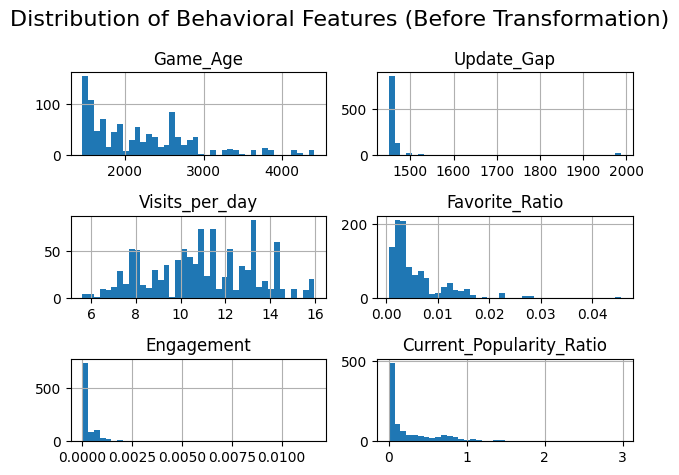

In [ ]:

# EDA 1: Feature Distributions (Histograms)
eda_features = [
    'Game_Age',
    'Update_Gap',
    'Visits_per_day',
    'Favorite_Ratio',
    'Engagement',
    'Current_Popularity_Ratio'
]

plt.figure(figsize=(14, 10))
df[eda_features].hist(bins=40)
plt.suptitle("Distribution of Behavioral Features (Before Transformation)", fontsize=16)
plt.tight_layout()
plt.show()


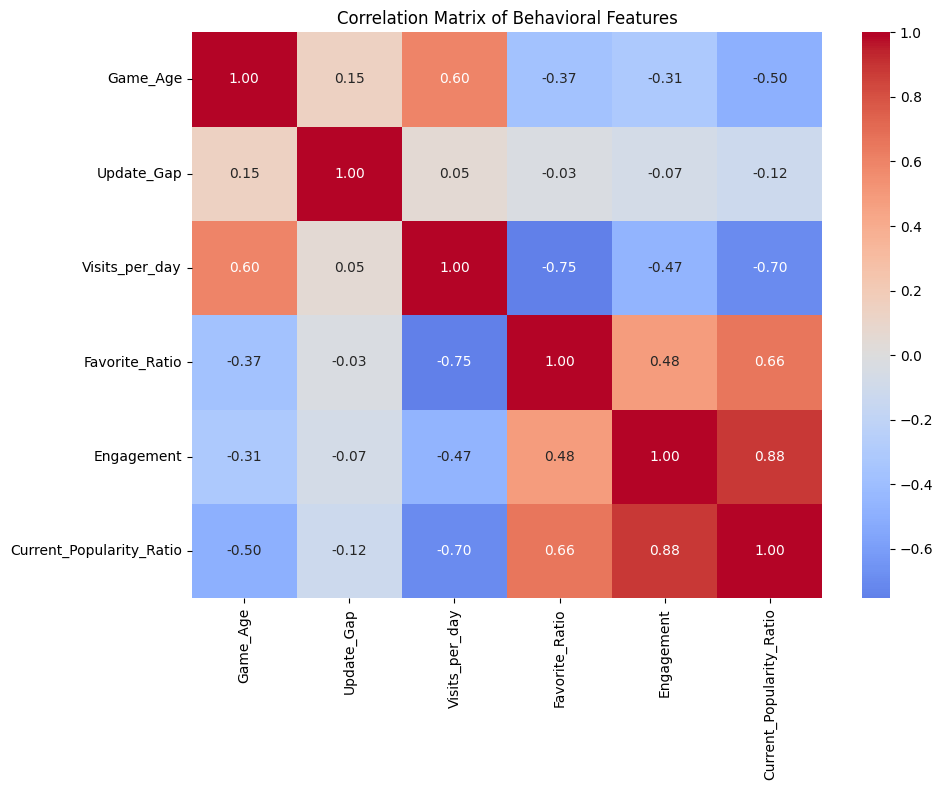

In [ ]:
# EDA 2: Correlation Heatmap

import seaborn as sns

corr = df[eda_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", center=0)
plt.title("Correlation Matrix of Behavioral Features")
plt.tight_layout()
plt.show()


Standardize the data

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Inspect cluster behaviour

DBScan

In [ ]:
dbscan = DBSCAN(
    eps=0.9,
    min_samples=20
)

db_labels = dbscan.fit_predict(X_scaled)

df['DBSCAN_Cluster'] = db_labels

print(df['DBSCAN_Cluster'].value_counts())

DBSCAN_Cluster
 0    937
-1     93
Name: count, dtype: int64


GMM

In [ ]:
gmm = GaussianMixture(
    n_components=3,
    covariance_type='full',
    random_state=42
)

gmm.fit(X_scaled)

print("Mixing Weights:")
print(gmm.weights_)

print("\nMeans:")
print(gmm.means_)

print("\nCovariances:")
print(gmm.covariances_)


Mixing Weights:
[0.42310002 0.51462335 0.06227663]

Means:
[[-0.5438636  -0.18426343 -0.62458269  0.34343806  0.01422087  0.29382414]
 [ 0.55740652  0.17595796  0.71696667 -0.53546414 -0.34677758 -0.59228992]
 [-0.91118801 -0.20216604 -1.68131856  2.09153441  2.76898412  2.89818573]]

Covariances:
[[[ 3.99830918e-01 -6.24448586e-04  1.22277051e-01 -6.47906278e-02
   -1.09667786e-01 -1.99490271e-01]
  [-6.24448586e-04  6.50422274e-04 -2.53268840e-03  4.17975842e-03
   -1.01838787e-03 -1.81248814e-03]
  [ 1.22277051e-01 -2.53268840e-03  3.72118645e-01 -3.88344307e-01
   -9.51230613e-02 -2.03706022e-01]
  [-6.47906278e-02  4.17975842e-03 -3.88344307e-01  7.72029260e-01
    7.99688731e-02  1.70364102e-01]
  [-1.09667786e-01 -1.01838787e-03 -9.51230613e-02  7.99688731e-02
    9.40300203e-02  1.88538086e-01]
  [-1.99490271e-01 -1.81248814e-03 -2.03706022e-01  1.70364102e-01
    1.88538086e-01  3.87946853e-01]]

 [[ 9.57302492e-01  8.32940181e-02  2.00312208e-01 -2.20163712e-03
   -7.20671020

Soft Clustering

In [ ]:
responsibilities = gmm.predict_proba(X_scaled)

responsibilities[:5]

array([[8.87341481e-001, 1.12658519e-001, 1.48655533e-018],
       [9.99991941e-001, 8.05932341e-006, 4.13068234e-049],
       [4.67714199e-035, 1.00000000e+000, 1.88502073e-240],
       [3.78557174e-014, 1.00000000e+000, 6.08148738e-101],
       [9.99827961e-001, 1.72038546e-004, 1.77999936e-046]])

Hard Clustering

In [ ]:
gmm_labels = gmm.predict(X_scaled)
df['GMM_Cluster'] = gmm_labels

Probabilities

In [ ]:
df['Prob_Cluster0'] = responsibilities[:,0]
df['Prob_Cluster1'] = responsibilities[:,1]
df['Prob_Cluster2'] = responsibilities[:,2]


Cluster Behaviours

In [ ]:
gmm_summary = df.groupby('GMM_Cluster')[features].mean()
gmm_summary

,Game_Age,Update_Gap,Visits_per_day,Favorite_Ratio,Engagement,Current_Popularity_Ratio
GMM_Cluster,,,,,,
0,1827.549654,1453.288684,9.529491,0.007649,0.000377,0.442783
1,2561.827392,1479.028143,12.648614,0.002751,0.000020,0.045892
2,1587.390625,1451.984375,7.086325,0.017308,0.003085,1.600557


With PCA

In [ ]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]
df['PCA3'] = X_pca[:, 2]

PCA Interpretation

In [ ]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]
df['PCA3'] = X_pca[:, 2]

# loadings (feature contributions)
loadings = pd.DataFrame(
    pca.components_.T,
    columns=['PCA1', 'PCA2', 'PCA3'],
    index=features
)

print("\nPCA Feature Contributions (Loadings):")
print(loadings)



PCA Feature Contributions (Loadings):
                              PCA1      PCA2      PCA3
Game_Age                 -0.362075  0.206345  0.601762
Update_Gap               -0.077619  0.959066 -0.136879
Visits_per_day           -0.474143 -0.071746  0.352831
Favorite_Ratio            0.443073  0.163831 -0.115886
Engagement                0.428292  0.071134  0.616129
Current_Popularity_Ratio  0.508249  0.023771  0.318767


In [ ]:
import seaborn as sns

# Create loadings dataframe
loadings = pd.DataFrame(
    pca.components_,
    columns=features,
    index=['PCA1', 'PCA2','PCA3']
)

print(loadings)


      Game_Age  Update_Gap  Visits_per_day  Favorite_Ratio  Engagement  \
PCA1 -0.362075   -0.077619       -0.474143        0.443073    0.428292   
PCA2  0.206345    0.959066       -0.071746        0.163831    0.071134   
PCA3  0.601762   -0.136879        0.352831       -0.115886    0.616129   

      Current_Popularity_Ratio  
PCA1                  0.508249  
PCA2                  0.023771  
PCA3                  0.318767  


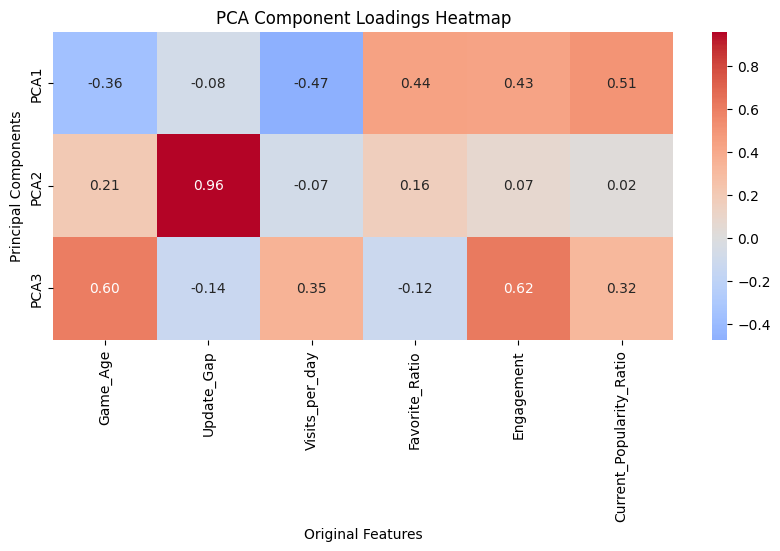

In [ ]:
plt.figure(figsize=(10,4))

sns.heatmap(
    loadings,
    annot=True,
    cmap='coolwarm',
    center=0,
    fmt=".2f"
)

plt.title("PCA Component Loadings Heatmap")
plt.xlabel("Original Features")
plt.ylabel("Principal Components")
plt.show()


In [ ]:
print("Explained Variance Ratio:")
print(pca.explained_variance_ratio_)


Explained Variance Ratio:
[0.55623204 0.16918378 0.13428578]


DBScan PCA

In [ ]:
import plotly.express as px

fig = px.scatter_3d(
    df,
    x='PCA1',
    y='PCA2',
    z='PCA3',
    color=df['DBSCAN_Cluster'].astype(str),
    opacity=0.5
)

fig.update_layout(title="DBSCAN Clusters in 3D PCA Space")
fig.show()


GMM PCA

In [ ]:
fig = px.scatter_3d(
    df,
    x='PCA1',
    y='PCA2',
    z='PCA3',
    color='GMM_Cluster',
    hover_data=[
        'Title',
        'Genre',
        'Visits_per_day',
        'Engagement',
        'Current_Popularity_Ratio'
    ],
    opacity=0.65
)

fig.update_layout(title="GMM Clusters")
fig.show()


Optimization

Elbow Checking

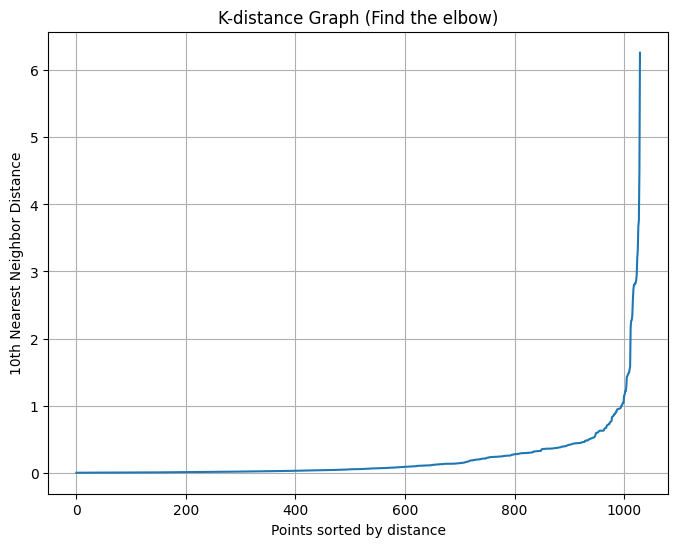

In [ ]:
neighbors = NearestNeighbors(n_neighbors=10)
neighbors_fit = neighbors.fit(X_scaled)

distances, indices = neighbors_fit.kneighbors(X_scaled)

# sort distances
distances = np.sort(distances[:,9])

plt.figure(figsize=(8,6))
plt.plot(distances)
plt.title("K-distance Graph (Find the elbow)")
plt.xlabel("Points sorted by distance")
plt.ylabel("10th Nearest Neighbor Distance")
plt.grid(True)
plt.show()


DBscan (Optimization)

In [ ]:

dbscan = DBSCAN(
    eps=0.85,
    min_samples=10
)

df['DBSCAN_Cluster'] = dbscan.fit_predict(X_scaled)


In [ ]:

labels = df['DBSCAN_Cluster']

# remove noise points
mask = labels != -1

if len(set(labels[mask])) > 1:
    score = silhouette_score(X_scaled[mask], labels[mask])
    print("DBSCAN Silhouette Score:", score)
else:
    print("DBSCAN produced only one cluster.")


DBSCAN Silhouette Score: 0.25256333280383675


GMM (Optimization)

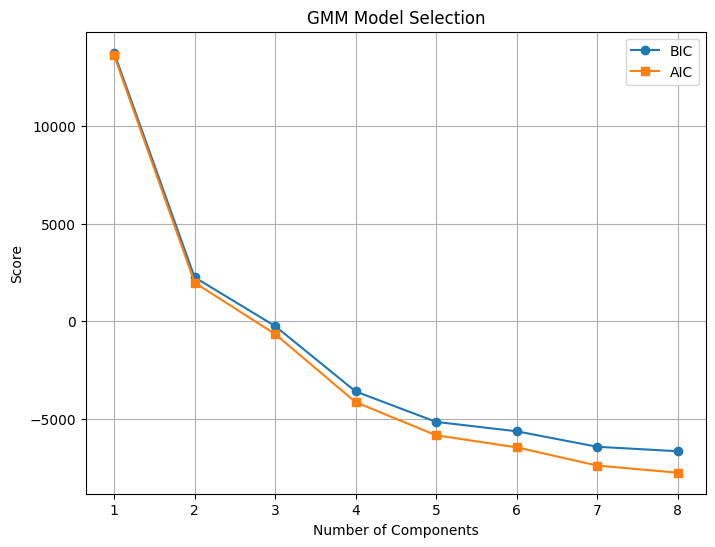

In [ ]:
from sklearn.mixture import GaussianMixture

bics = []
aics = []
ks = range(1,9)

for k in ks:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm.fit(X_scaled)

    bics.append(gmm.bic(X_scaled))
    aics.append(gmm.aic(X_scaled))

plt.figure(figsize=(8,6))
plt.plot(ks, bics, marker='o', label="BIC")
plt.plot(ks, aics, marker='s', label="AIC")
plt.xlabel("Number of Components")
plt.ylabel("Score")
plt.title("GMM Model Selection")
plt.legend()
plt.grid(True)
plt.show()


GMM with optimal K

In [ ]:
k_optimal = 3

gmm_opt = GaussianMixture(
    n_components=k_optimal,
    covariance_type='full',
    random_state=42,
    n_init=20
)

gmm_opt.fit(X_scaled)

df['Cluster'] = gmm_opt.predict(X_scaled)


Cluster Interpretation and Evaluation

In [ ]:
summary = df.groupby('Cluster')[[
    'Game_Age',
    'Visits_per_day',
    'Current_Popularity_Ratio',
    'Engagement'
]].mean()

print(summary)


            Game_Age  Visits_per_day  Current_Popularity_Ratio  Engagement
Cluster                                                                   
0        2492.786499       12.324024                  0.065936    0.000030
1        1653.302139        8.705876                  0.738749    0.000942
2        2744.000000       11.321305                  0.017251    0.000006


In [ ]:
label_map = {
    1: "Mainstream",
    0: "Average",
    2: "One-Hit Wonder"
}

df['Game_Type'] = df['Cluster'].map(label_map)


In [ ]:
probs = gmm_opt.predict_proba(X_scaled)

for i in range(k_optimal):
    df[f'GMM_Prob_{i}'] = probs[:,i]


In [ ]:
gmm_score = silhouette_score(X_scaled, df['Cluster'])
print("Final GMM Silhouette Score:", gmm_score)

Final GMM Silhouette Score: 0.44203120768314136


Cluster Distribution Overview

In [ ]:
print(df['GMM_Cluster'].value_counts())
print((df['DBSCAN_Cluster'] == -1).sum(), "outlier games detected")


GMM_Cluster
1    533
0    433
2     64
Name: count, dtype: int64
35 outlier games detected
